In [1]:
from matplotlib import pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from os.path import join, dirname, abspath
import shap
import tqdm

/opt/homebrew/Caskroom/miniconda/base/envs/SaaLab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
metadata = pd.read_csv(join('..', 'Data', 'metadata.csv')).dropna()
metadata['sample_id'] = metadata['sample_id'].apply(lambda x: str(x).replace('.', '-'))
metadata
metadata.set_index('sample_id', inplace = True)
exist_data = pd.read_csv(join('..', 'Data', 'exist.csv'))
exist_data = exist_data.T 
exist_data.columns = exist_data.iloc[0]
exist_data = exist_data[1:]
### Combine metadata and PCA results
metadata_things = metadata[['sex', 'age', 'type_person', 'diagnosis', 'appendectomy', 'smoking']]

concat_pep_meta = pd.concat([metadata_things, exist_data], axis = 1)


In [3]:
def smoking(x):
    if x == 'Never':
        return 0
    elif x == 'Ex_smoker':
        return 1
    elif x == 'Current_smoker':
        return 2
    else:
        return np.nan
    
    
X = concat_pep_meta.copy()
X.drop(columns = ['type_person', 'diagnosis'], inplace = True)
# encoding
X['sex'] = X['sex'].apply(lambda x: 0 if x == 'Male' else 1)

X['appendectomy'] = X['appendectomy'].apply(lambda x: 0 if x == 'No' else 1)
X['smoking'] = X['smoking'].apply(lambda x: smoking(x))
X = X.astype('category')
y = concat_pep_meta['type_person']
y = y.apply(lambda x: 0 if x == 'Control' else 1)

In [4]:
# feature selection
from sklearn.model_selection import LeaveOneOut
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1,
    'seed': 100,
    'alpha': 0.2
}
loo = LeaveOneOut()

importance = []
for x in tqdm.tqdm(loo.split(X), total=X.shape[0], desc='Leave-One-Out Cross-Validation'):
    train_index, test_index = x
    bst = XGBClassifier(**params, n_estimators=100, enable_categorical=True)
    bst.fit(X.iloc[train_index], y.iloc[train_index]) 
    shap_exp = shap.TreeExplainer(bst)
    shap_values = shap_exp.shap_values(X.iloc[test_index])
    importance.append(np.abs(shap_values).mean(axis=0))





Leave-One-Out Cross-Validation: 100%|██████████| 80/80 [08:42<00:00,  6.53s/it]


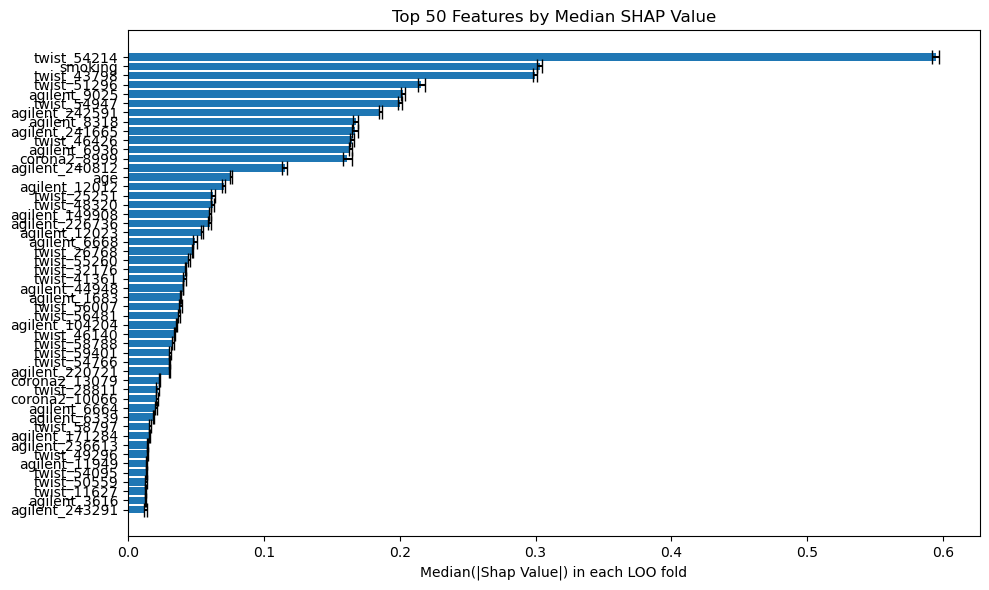

In [ ]:
# convert to pandas
importance_df = pd.DataFrame(importance, columns=X.columns)

median_importance = importance_df.median(axis = 0).sort_values(ascending=False)
std_importance = importance_df.std(axis = 0).sort_values(ascending=False)   
im_50_best = median_importance[:50]
im_50_best_std = std_importance[im_50_best.index]/80 # std error

# Plotting the feature importance
plt.figure(figsize=(10, 6))
plt.barh(im_50_best.index, im_50_best.values, xerr=im_50_best_std.values, capsize=5)
plt.xlabel('Median(|Shap Value|) in each LOO fold')
plt.title('Top 50 Features by Median SHAP Value')
plt.gca().invert_yaxis()  
plt.tight_layout()

In [27]:
pep_best_shap = pd.concat([im_50_best, im_50_best_std], axis = 1)
pep_best_shap.columns = ['median_shap', 'std_error']
pep_best_shap.to_csv(join('..', 'Results', 'Smoking_Xgboost_Top50_SHAP.csv'))

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeavePOut, KFold
from sklearn.model_selection import StratifiedKFold
n_features = 150
dict_cross_val = {
    'mean_accuracy': [],
    'std_accuracy': [],
    'mean_roc_auc': [],
    'std_roc_auc': [],
}

for i in tqdm.tqdm(range(n_features)):
    names = median_importance[:i+1].index.to_list()
    X_subset = X[names]
    cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=42)
    bst = XGBClassifier(**params, n_estimators=100, enable_categorical=True)
    scores = cross_val_score(bst, X_subset, y, cv=cv, scoring='accuracy', n_jobs=-1)
    dict_cross_val['mean_accuracy'].append(scores.mean())
    dict_cross_val['std_accuracy'].append(scores.std())
    scores_2 = cross_val_score(bst, X_subset, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    dict_cross_val['mean_roc_auc'].append(scores_2.mean())
    dict_cross_val['std_roc_auc'].append(scores_2.std())

100%|██████████| 150/150 [00:33<00:00,  4.45it/s]


In [7]:
dict_cross_val['num_features'] = list(range(1, n_features + 1))

Text(0, 0.5, 'Mean RUC AUC')

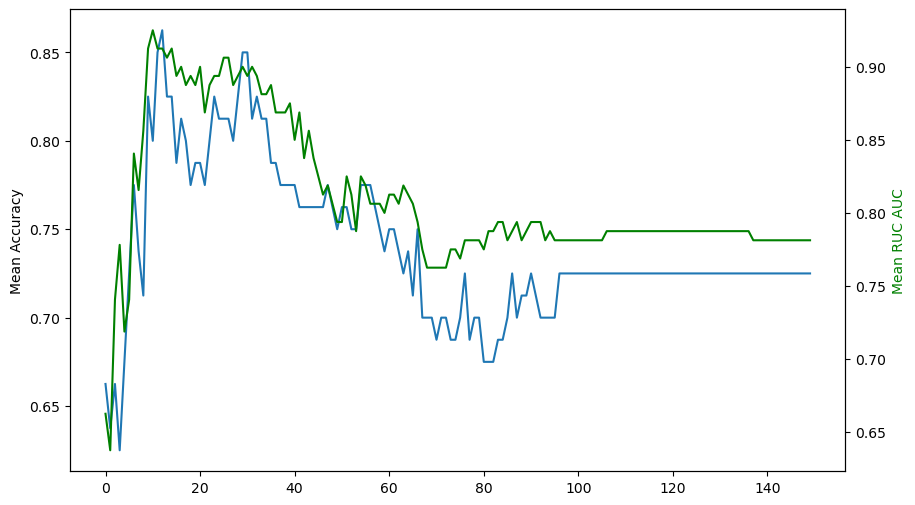

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(dict_cross_val['mean_accuracy'])
ax.set_ylabel('Mean Accuracy')
axt = ax.twinx()
axt.plot(dict_cross_val['mean_roc_auc'], color = 'green')
axt.set_ylabel('Mean RUC AUC', color = 'green')

In [9]:
dict_cross_val['n_features'] = list(range(1, n_features + 1))
cross_val_df = pd.DataFrame(dict_cross_val)
# features = median_importance.index[:50].to_list()
cross_val_df.sort_values(by='mean_accuracy', ascending=False, inplace=True)
cross_val_df

,mean_accuracy,std_accuracy,mean_roc_auc,std_roc_auc,num_features,n_features
12,0.8625,0.103833,0.912500,0.097628,13,13
29,0.8500,0.122474,0.900000,0.112500,30,30
30,0.8500,0.122474,0.893750,0.118750,31,31
11,0.8500,0.134629,0.912500,0.101550,12,12
28,0.8250,0.139194,0.893750,0.118750,29,29
...,...,...,...,...,...,...
4,0.6750,0.178536,0.718750,0.189572,5,5
2,0.6625,0.168170,0.740625,0.235124,3,3
0,0.6625,0.209538,0.662500,0.209538,1,1
1,0.6375,0.197247,0.637500,0.259281,2,2


64 16
64 16
64 16
64 16
64 16


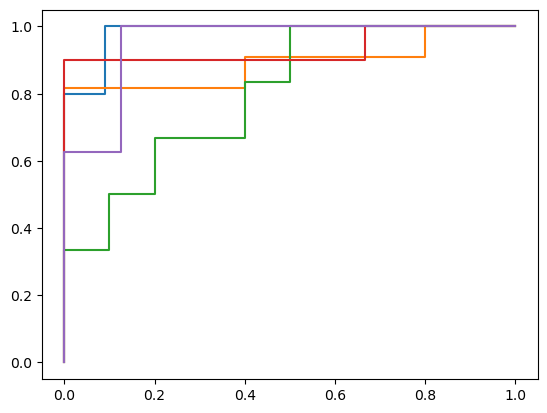

In [10]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
features = median_importance.index[:13].to_list()
X_subset = X[features]

fold = KFold(n_splits=5, shuffle=True, random_state=42)
fig, ax = plt.subplots()
for i_train, i_test in fold.split(X_subset, y):
    X_train, X_test = X_subset.iloc[i_train], X_subset.iloc[i_test]
    y_train, y_test = y.iloc[i_train], y.iloc[i_test]
    print(len(y_train), len(y_test))
    
    bst = XGBClassifier(
        **params, n_estimators=100, enable_categorical=True
    )
    bst.fit(X_train, y_train)
    
    y_prob = bst.predict_proba(X_test)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    ax.plot(fpr, tpr, label='ROC Curve')

In [11]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
features = median_importance.index[:31].to_list()
X_subset = X[features]


bst = XGBClassifier(
    **params, n_estimators=100, enable_categorical=True
)
bst.fit(X_subset, y)
    
shap_values = shap.TreeExplainer(bst).shap_values(X_subset)



In [12]:
X_subset

,twist_54214,smoking,twist_43798,twist_51296,agilent_9025,twist_54947,agilent_242591,agilent_8318,agilent_241665,twist_46426,...,twist_26768,twist_55260,twist_32176,twist_41361,agilent_44948,agilent_1683,twist_56007,twist_56481,agilent_104204,twist_46140
R33P01_01_N003_IBD-Chile_A_T_C2,0,0,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
R33P01_02_N006_IBD-Chile_A_T_C2,0,0,0,1,1,0,1,0,1,1,...,1,0,0,0,0,1,0,1,1,0
R33P01_03_N008_IBD-Chile_A_T_C2,1,0,0,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
R33P01_04_N011_IBD-Chile_A_T_C2,0,0,0,0,1,0,1,0,1,0,...,1,0,1,0,0,1,0,1,1,1
R33P01_05_N013_IBD-Chile_A_T_C2,1,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R33P01_76_N082_IBD-Chile_A_T_C2,0,1,1,1,0,0,1,1,0,1,...,1,0,1,0,0,1,0,0,0,1
R33P01_77_N085_IBD-Chile_A_T_C2,0,0,1,1,0,1,0,1,0,1,...,1,1,0,0,0,1,1,0,0,1
R33P01_78_N091_IBD-Chile_A_T_C2,0,0,1,0,1,0,1,1,0,0,...,1,1,1,0,0,0,0,0,0,1
R33P01_79_N092_IBD-Chile_A_T_C2,1,2,0,1,0,1,1,1,0,1,...,0,0,1,0,0,1,1,1,1,0


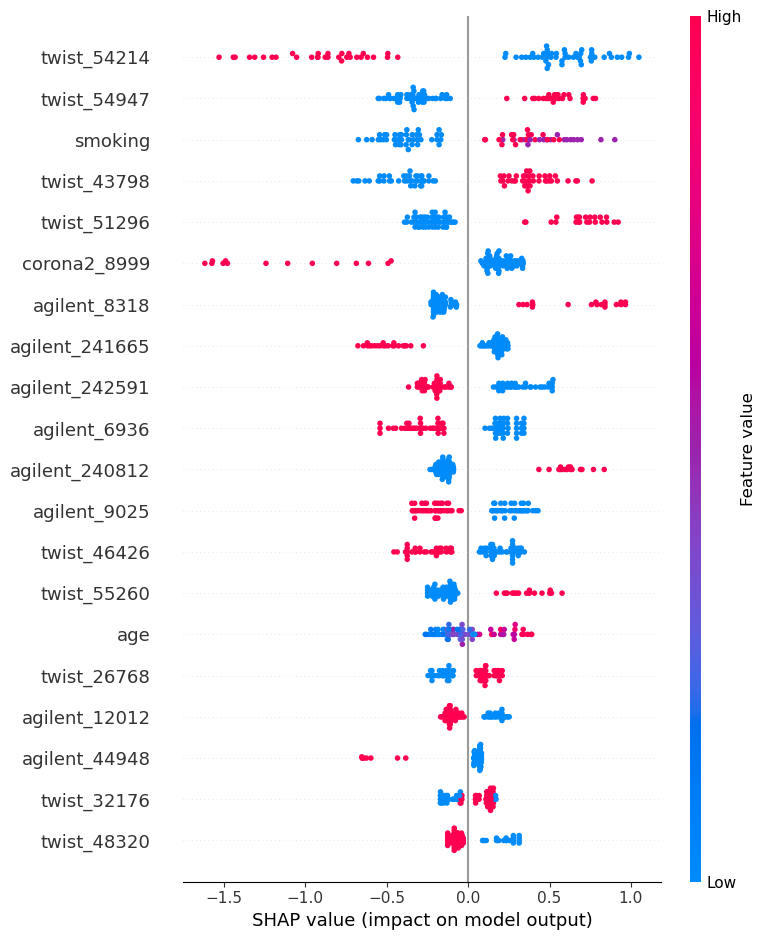

In [13]:
shap.summary_plot(shap_values, X_subset.astype('float64'))

In [14]:
shap_interaction_values = shap.TreeExplainer(bst).shap_interaction_values(X_subset.astype('float64'))

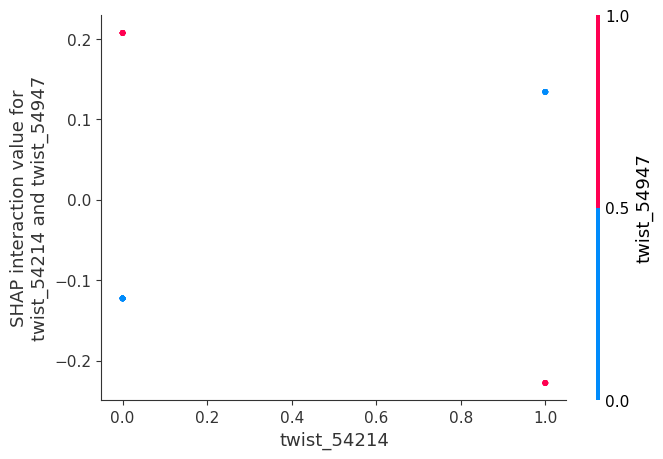

In [15]:
shap.dependence_plot(("twist_54214", 'twist_54947'), shap_interaction_values, X_subset)